# Shea Ackers Modeling of Gal4 -- removing cooperative promoters
The basic strategy here is to use the fast shea ackers model that Nik built and applied to Gal4 but to remove promoters for which Gal4 is likely bound through a cooperative interaction. This was done mostly in Matlab, but the front end and back end can be done in python. Ultimately, I'd like to do everything in python.

To use the model, we first need to make two text files: an epsilon matrix, which is just the free energies of binding for each site for each promoter, and a hops.txt (or TPH.txt) file. These files have to have the same ordering -- row one in the hops.txt file has to give the TPH score of the same promoter that is described by row one of the hops.txt file. These files can be generated from the comparison frame.

##  Translating from a PWM to a Free Energy Matrix
We have PWMs for all TFs.  How can one translate from a PWM to a free energy matrix?  There are several treatments of this.  Berg and von Hippel have the original work, which is pretty opaque.  Stormo and Fields have a review, but I think the equation is wrong.  The best is "Neural networks for determining protein specificity and multiple alignment of binding sites" by Heumann, Lapedes and Stormo 1994.  

They derive the following relationship between a PWM and the frequency matrix (equation 19 in the paper):

$$W(b,m) = -ln \frac{F(b,m)}{p(b)} $$

Since a PWM has the equation:
$$PWM(b,m) = log_2\frac{F(b,m)}{p(b)}$$

These can be converted by:
$$W(b,m) = -ln(2)*PWM(b,m)$$

However, I got all of my PWMs from Aaron Spivak's database.  He made PFMs and PWMs, but he did not correctly convert the PFM to PWM.  He used 

$$PWM_{Spivak}(b,m) = ln \frac{F(b,m)}{p(b)}$$

where $p(b) =$ {"A":0.32,"C":0.18,"G":0.18,"T":0.32} instead of the usual $p(b)=$ {"A":0.31,"C":0.19,"G":0.19,"T":0.31}

So, to convert a Spivak PWM to a free energy matrix, ignoring the small difference in $p(b)$, one simply does the following:

$$W(b,m) = -PWM_{Spivak}(b,m)$$

In [1]:
cd ./gal4_shea_ackers

/scratch/rmlab/jupyter/Rob/gal4_shea_ackers


In [2]:
from analyze_sig_hits_v2 import *

In [3]:
cf = make_comparison_frame('./sig_prom_FL-Gal4_AC_gnashy.txt.txt',
                           './sig_prom_DBD-Gal4_CGT_gnashy.txt.txt'
                           ,'Gal4_FL','Gal4_DBD',True,True)

/opt/apps/pybedtools/0.7.7/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
cf.head()

,Gal4_FL TPH BS,Gal4_FL pvalue,Gal4_DBD TPH BS,Gal4_DBD pvalue,Sequence,Log2FC,Left Common Name,Right Common Name
Intergenic Region,,,,,,,,
Chr12: 289251-290213,5177.360227,0.0,3111.753813,0.000000e+00,"(T, G, C, C, A, A, G, C, T, G, T, A, T, G, G, ...",-0.734489,EMP46,GAL2
Chr2: 278352-279021,5025.926713,0.0,6105.735075,0.000000e+00,"(A, A, T, C, A, T, A, A, G, T, T, G, A, A, T, ...",0.280775,GAL10,GAL1
Chr2: 275527-276253,3989.213470,0.0,4346.788827,0.000000e+00,"(C, A, T, A, C, A, A, T, G, G, A, G, C, T, G, ...",0.123846,GAL7,GAL10
Chr11: 613527-615372,2904.030942,0.0,229.919902,9.328205e-12,"(C, G, C, C, G, C, T, A, G, A, A, C, T, G, G, ...",-3.658854,SRP40,PTR2
Chr11: 229524-231871,2429.110886,0.0,-21.238411,7.247590e-01,"(T, T, A, T, G, C, C, T, A, A, A, G, A, T, T, ...",NaN,KTI12,HAP4


# Making an Epsilon File for Shea-Ackers in matlab
In principle, we could compute the free energy of binding for every base pair in all bound and/or unbound promoters. However, for Gal4, I put a cutoff to only select the strong sites, since very weak sites will not contribute much, if anything to the computation, and the code will run much faster this way. I will do the same here, using a PWM/Free Energy cutoff of 9. Also, since matlab likes matrices, I square the matrix by adding 999's to the matrix. So the procedure is 1) grab bound and some unbound sites. 2) Score the sequences with the Spivak PWM with a cutoff of zero and multiply by -1. 3) Square the matrix by adding 999's to the matrix. 4) Print the matrix to a file

In [5]:
gal4_bound = cf[cf["Gal4_FL pvalue"]<1.1e-5]

In [6]:
len(gal4_bound)

61

In [7]:
gal4_for_epsilon = gal4_bound.copy()

In [8]:
gal4_for_epsilon = add_pwm_info(gal4_for_epsilon,'gal4',8)

In [9]:
gal4_for_epsilon

,Gal4_FL TPH BS,Gal4_FL pvalue,Gal4_DBD TPH BS,Gal4_DBD pvalue,Sequence,Log2FC,Left Common Name,Right Common Name,gal4 pos,gal4 score,gal4 orientaion
Intergenic Region,,,,,,,,,,,
Chr12: 289251-290213,5177.360227,0.000000e+00,3111.753813,0.000000e+00,"(T, G, C, C, A, A, G, C, T, G, T, A, T, G, G, ...",-0.734489,EMP46,GAL2,"[599, 713, 716, 796]","[9.97, 12.27, 11.64, 16.12]","[-1, -1, 1, -1]"
Chr2: 278352-279021,5025.926713,0.000000e+00,6105.735075,0.000000e+00,"(A, A, T, C, A, T, A, A, G, T, T, G, A, A, T, ...",0.280775,GAL10,GAL1,"[402, 404, 468]","[15.0, 13.69, 13.35]","[-1, 1, 1]"
Chr2: 275527-276253,3989.213470,0.000000e+00,4346.788827,0.000000e+00,"(C, A, T, A, C, A, A, T, G, G, A, G, C, T, G, ...",0.123846,GAL7,GAL10,"[327, 414]","[13.49, 12.72]","[1, 1]"
Chr11: 613527-615372,2904.030942,0.000000e+00,229.919902,9.328205e-12,"(C, G, C, C, G, C, T, A, G, A, A, C, T, G, G, ...",-3.658854,SRP40,PTR2,[],[],[]
Chr11: 229524-231871,2429.110886,0.000000e+00,-21.238411,7.247590e-01,"(T, T, A, T, G, C, C, T, A, A, A, G, A, T, T, ...",NaN,KTI12,HAP4,[],[],[]
Chr4: 1488983-1490589,2377.140132,0.000000e+00,108.742941,2.035394e-04,"(T, A, C, A, T, C, G, A, A, G, A, G, A, T, T, ...",-4.450233,AGE1,SNA2,[],[],[]
Chr4: 368211-369769,1705.183784,0.000000e+00,301.674933,0.000000e+00,"(C, T, A, T, C, A, A, A, T, G, G, T, G, A, A, ...",-2.498861,STP4,SIT4,[],[],[]
Chr5: 117474-120498,1235.573432,0.000000e+00,658.810710,0.000000e+00,"(C, T, G, T, G, T, C, A, A, T, G, A, C, T, T, ...",-0.907245,TIM9,MMS21,[3150],[9.49],[-1]
Chr12: 442738-445525,913.618139,0.000000e+00,404.117011,0.000000e+00,"(T, C, A, T, T, C, C, A, A, T, G, A, A, T, A, ...",-1.176818,PCD1,ACS2,[],[],[]


In [10]:
def compute_distance(x):
    if x:
        return x[-1] - x[0]
    else:
        return 0

In [11]:
gal4_for_epsilon["site_distance"]=gal4_for_epsilon["gal4 pos"].apply(lambda x: compute_distance(x))

In [12]:
gal4_for_epsilon["num_sites"]=gal4_for_epsilon["gal4 pos"].apply(lambda x: len(x)) #all gal4 bound promoters excluding indirect interactions

In [13]:
gal4_for_epsilon_all = gal4_for_epsilon.copy()  #all gal4 bound promoters

In [14]:
gal4_for_epsilon = gal4_for_epsilon[gal4_for_epsilon["num_sites"]>0]

In [15]:
len(gal4_for_epsilon)

23

In [16]:
epsilon_series = gal4_for_epsilon["gal4 score"].apply(lambda x: [y*-1 for y in x])

epsilon_series_all = gal4_for_epsilon_all["gal4 score"].apply(lambda x: [y*-1 for y in x])

In [17]:
epsilon_series.head()

Intergenic Region
Chr12: 289251-290213    [-9.97, -12.27, -11.64, -16.12]
Chr2: 278352-279021             [-15.0, -13.69, -13.35]
Chr2: 275527-276253                    [-13.49, -12.72]
Chr5: 117474-120498                             [-9.49]
Chr15: 586325-586982                           [-13.01]
Name: gal4 score, dtype: object

In [18]:
max_sites = max(epsilon_series.apply(len))

max_sites_all = max(epsilon_series_all.apply(len))

epsilon_series = epsilon_series.apply(lambda x: x+[999]*(max_sites-len(x)))
epsilon_series_all = epsilon_series_all.apply(lambda x: x+[999]*(max_sites-len(x)))

In [19]:
len(epsilon_series_all)

61

In [20]:
f1=open('./epsilon_gal4.txt', 'w+')

for line in epsilon_series:
    print >> f1,"\t".join(map(str,line)) 

f1.close()

f1=open('./epsilon_gal4_all.txt', 'w+')

for line in epsilon_series_all:
    print >> f1,"\t".join(map(str,line)) 

f1.close()

## Making the TPHBS_Gal4.txt file

In [21]:
hops = gal4_for_epsilon["Gal4_FL TPH BS"]
hops_all = gal4_for_epsilon_all["Gal4_FL TPH BS"]

In [22]:
f1=open('./TPHBS_gal4.txt', 'w+')

for line in hops:
    print >> f1,line

f1.close()

f1=open('./TPHBS_gal4_all.txt', 'w+')

for line in hops_all:
    print >> f1,line

f1.close()

In [23]:
run thermo3

In [24]:
epsilon = pd.read_csv("epsilon_gal4.txt",sep="\t",header=None)

In [25]:
hops = pd.read_csv("TPHBS_gal4.txt",sep="\t",header=None)

Correlation = 0.97


/opt/apps/matplotlib/2.0.0/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


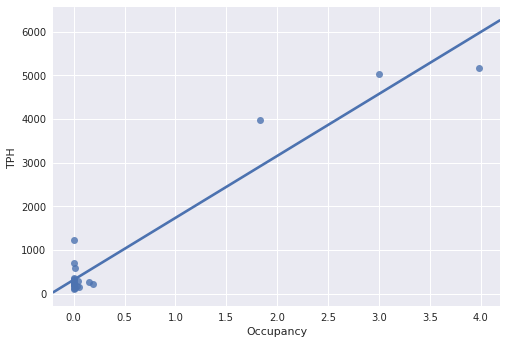

In [26]:
outframe = fast_shea_ackers_series(epsilon,hops,1,-13,0.00000001)

In [27]:
len(hops)

23

Correlation = 0.18


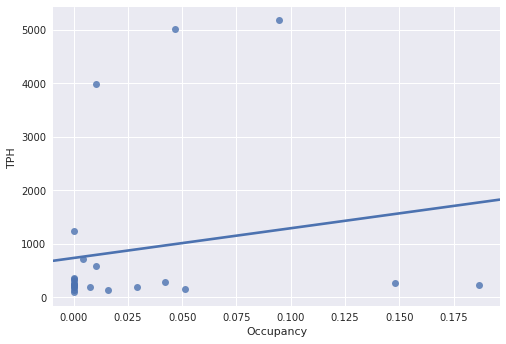

In [28]:
outframe = fast_shea_ackers_series(epsilon,hops,1,0,0.00000001)

In [29]:
epsilon = pd.read_csv("epsilon_gal4_all.txt",sep="\t",header=None)

In [30]:
hops = pd.read_csv("TPHBS_gal4_all.txt",sep="\t",header=None)

Correlation = 0.79


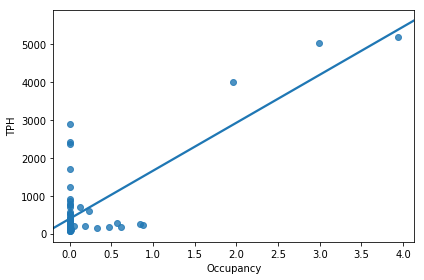

In [47]:
outframe_coop = fast_shea_ackers_series(epsilon,hops,1,-8,0.0000003)

Correlation = 0.33


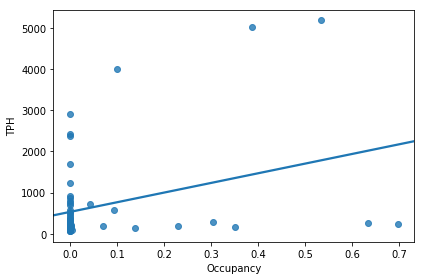

In [48]:
outframe_nocoop = fast_shea_ackers_series(epsilon,hops,1,0,0.0000001)

In [33]:
sns.reset_orig()

In [34]:
run ~/scratch/jupyter/Rob/gal4_scatterplot.py

In [35]:
outframe_coop.columns = ["Predicted Occupancy","Observed Binding (TPH)"]

0.836660026534
(0.83666650173168589, 4.610358295454393e-17)


/opt/apps/matplotlib/2.0.0/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


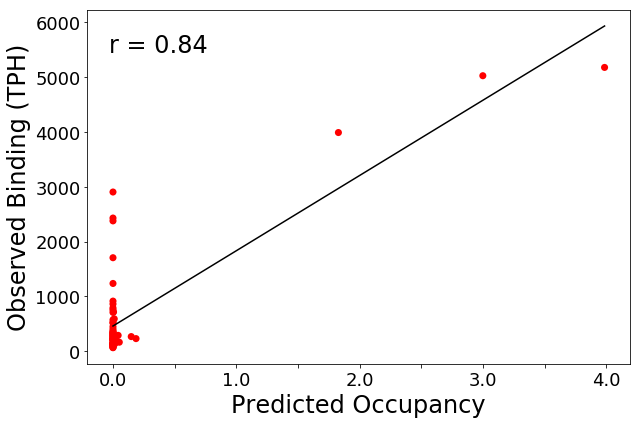

In [36]:
scatterplot_cc(outframe_coop,"Predicted Occupancy","Observed Binding (TPH)")

In [37]:
outframe_nocoop.columns = ["Predicted Occupancy","Observed Binding (TPH)"]

0.2
(0.2063240819764367, 0.11064005599383724)


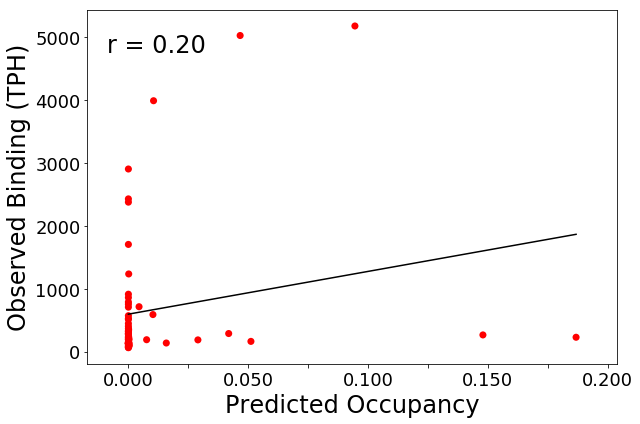

In [38]:
scatterplot_cc(outframe_nocoop,"Predicted Occupancy","Observed Binding (TPH)")